Checking what type of gpu we have been alotted

In [1]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


Step 1: Importing necessary libraries

In [2]:
import re
import gc
import os
import glob
import keras
import pandas as pd
import numpy  as np
import itertools
from sklearn.metrics import confusion_matrix
from collections import Counter

import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import roc_curve, auc, multilabel_confusion_matrix


import keras.backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection   import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Step 2: Setting up general parameters

In [3]:
# General parameters
batch_size = 128
epochs = 50
pic_size = 48
np.random.seed(42)
tf.random.set_seed(42)

Step 3: Data Preparation

In [4]:
folder_path = "images"

In [5]:
def plot_exp(expression):
    plt.style.use('dark_background')
    plt.figure(figsize= (12,12))
    for i in range(1, 10, 1):
        plt.subplot(3,3,i)
        img = load_img(folder_path+"\\train"+"\\"+expression+"\\"+
                  os.listdir(folder_path+"\\train"+"\\"+expression+"\\")[i], target_size=(pic_size, pic_size))
        plt.imshow(img)   
    plt.show()

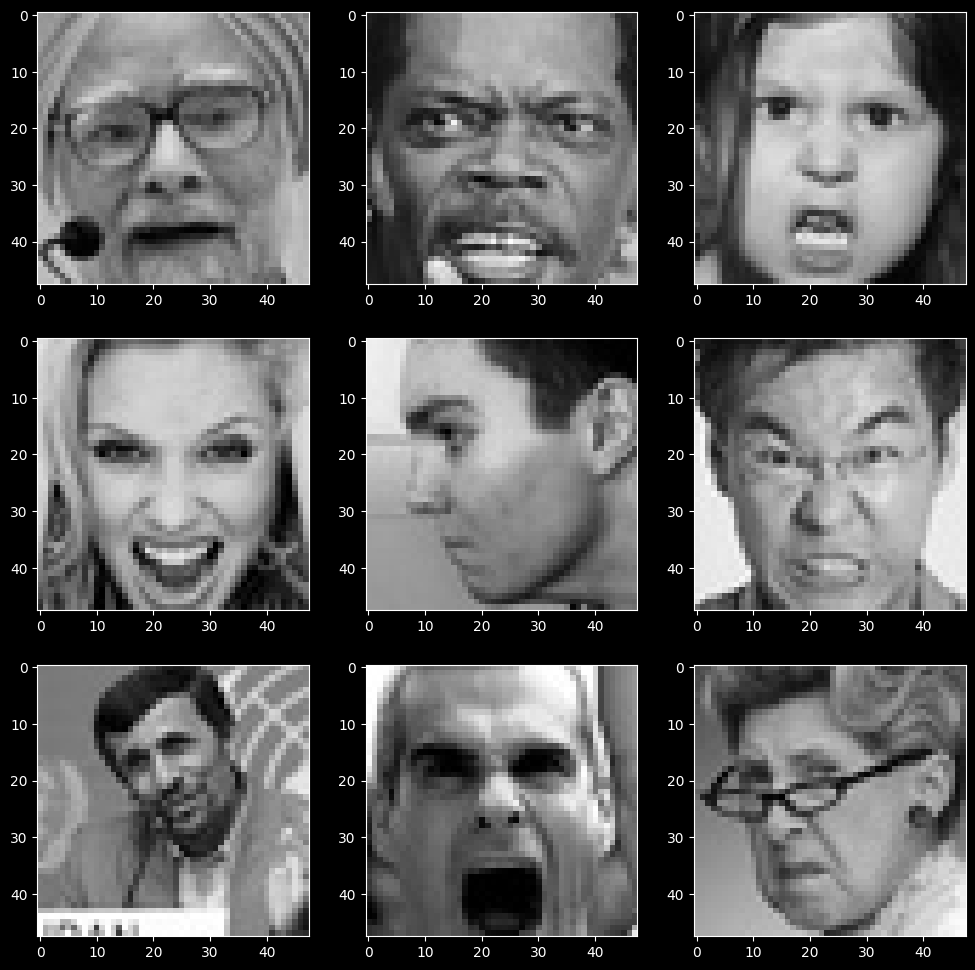

In [6]:
plot_exp('angry')

In [7]:
def walk_data(mydict, folder_path):
    for (root,dirs,files) in os.walk(folder_path, topdown=False):
        if len(files)>0:
            mydict[root]=len(files)

In [8]:
train_dict = dict()
val_dict = dict()
walk_data(train_dict, folder_path + "\\train")
walk_data(val_dict, folder_path + "\\validation")

In [9]:
def fix_keys(mydict):
    new_dict = dict()
    for k, v in mydict.items():
        new_k = k.split('\\')[-1]
        new_dict[new_k] = v
    return new_dict

In [10]:
train_dict = fix_keys(train_dict)
val_dict = fix_keys(val_dict)
print(train_dict)
print(val_dict)

{'angry': 3993, 'disgust': 436, 'fear': 4103, 'happy': 7164, 'neutral': 4982, 'sad': 4938, 'surprise': 3205}
{'angry': 960, 'disgust': 111, 'fear': 1018, 'happy': 1825, 'neutral': 1216, 'sad': 1139, 'surprise': 797}


In [11]:
label_train_dict = {'Expressions':train_dict.keys(), 'Count':train_dict.values}
label_val_dict = {'Expressions':val_dict.keys(), 'Count':val_dict.values}

In [12]:
def plot_dist(my_dict, data):
    fig = px.bar(x=my_dict.values(),
             y=my_dict.keys(),
             orientation='h',
             color=my_dict.values(),
             title=data + ' Distribution',
             opacity=0.8,
             color_discrete_sequence=px.colors.diverging.curl,
             template='plotly_dark'
            )
    fig.update_xaxes()
    fig.show()

# plot_dist(train_dict, "Training data")

In [13]:
plot_dist(val_dict, "Validation data")

Step 4: Generating the data suitable format for the model using ImageGenerator

In [14]:
datagen_train  = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
datagen_val = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

train_set = datagen_train.flow_from_directory(folder_path+"\\train",
                                              target_size = (pic_size,pic_size),
                                              color_mode = "rgb",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(folder_path+"\\validation",
                                              target_size = (pic_size,pic_size),
                                              color_mode = "rgb",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

counter = Counter(train_set.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()} 

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [19]:
from tensorflow.keras.models import load_model
# # Create and compile model
# model = Sequential()
# model.add(ResNet50(input_shape=(pic_size, pic_size, 3), weights='imagenet', include_top=False))
# model.add(GlobalMaxPooling2D())
# model.add(Dropout(0.5))
# model.add(Dense(7,activation='softmax'))
def create_model(input_shape=(48, 48, 3), num_classes=7):
    model = Sequential()
    model.add(ResNet50(input_shape=input_shape, weights='imagenet', include_top=False, input_tensor=None))
    model.add(GlobalMaxPooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and summarize the model
model = create_model()
model.summary()

# Save the model
model.save("clean_model.keras")

# Load the model
loaded_model = load_model("clean_model.keras")

# Verify the loaded model
loaded_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_1          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

c:\Users\Aditee\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_api.py:100: UserWarning:

You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_1          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [16]:
# model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

Step 5: Evaluate the model

In [20]:
results = model.evaluate(test_set)
preds   = model.predict(test_set)
print('The current model achieved a categorical accuracy of {}%!'.format(round(results[1]*100,2)))

c:\Users\Aditee\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 235ms/step - accuracy: 0.1899 - loss: 4.8767
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 258ms/step
The current model achieved a categorical accuracy of 12.91%!


In [21]:
# compute predictions
predictions = model.predict(test_set)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_set.classes
class_names = test_set.class_indices.keys()

56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 237ms/step


In [22]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

<Figure size 640x480 with 0 Axes>

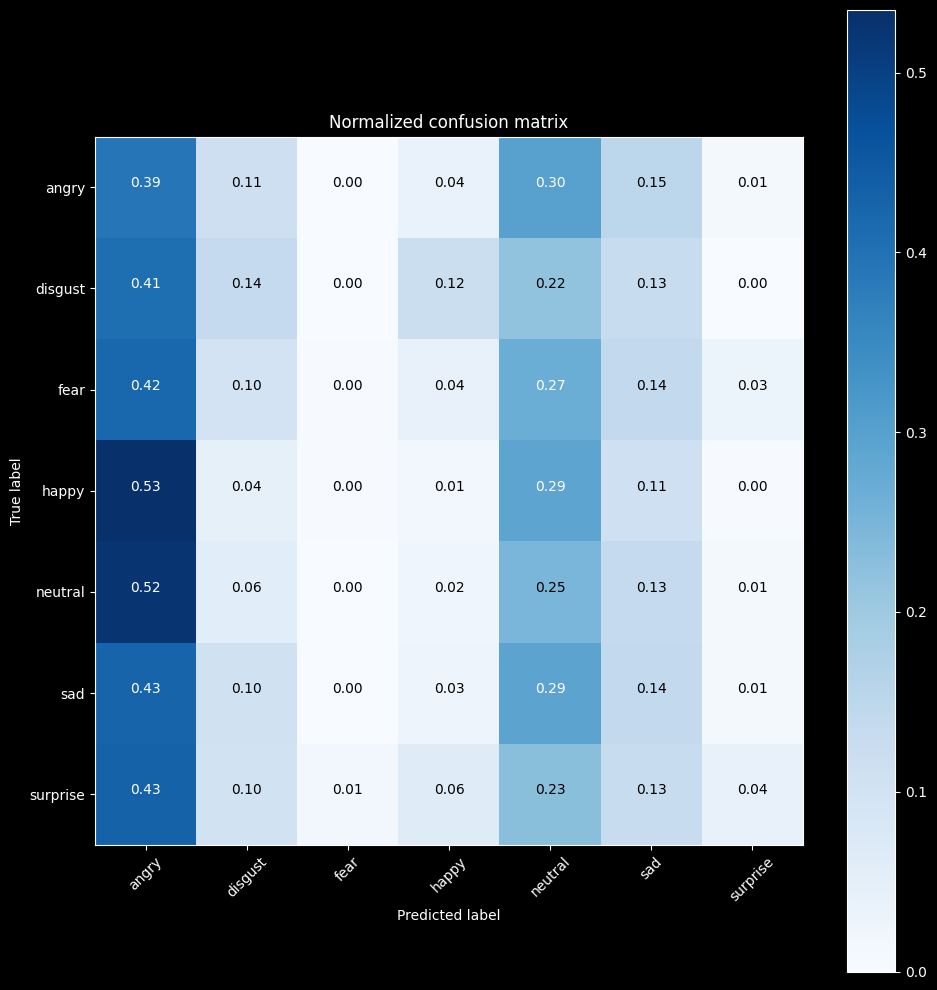

In [23]:
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

Step 6: Integration with OpenCv for live expression recognition

The code here first loads the model then loads a pre-trained haar-cascade to detect faces in the image then we take a stream of images from the webcam then for each image we detect faces, extract them then feeds them to the model in order to predict the expression of the face then display a bounding box around the face with the expression labeled on top of it.

In [24]:
# model.save("FEC_model.keras", overwrite=True)
# #model.save("FEC_model.h5")



In [25]:
# model.summary()


In [26]:
# Create and summarize the model
model = create_model()
model.summary()

# Save the model
model.save("clean_model.keras")

# Load the model
loaded_model = load_model("clean_model.keras")

# Verify the loaded model
loaded_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_2          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

c:\Users\Aditee\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_api.py:100: UserWarning:

You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_2          │ ?                      │   0 (unbuilt) │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [27]:
def load_and_return_model(filepath, custom_objects=None, compile=True, safe_mode=True):
    return load_model(
        filepath=filepath,
        custom_objects=custom_objects,
        compile=compile,
        safe_mode=safe_mode
    )

# Load the model
model = load_and_return_model('clean_model.keras')


In [28]:
class LiveDetection(object):
    def __init__(self):
        self.face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
        self.model = tf.keras.models.load_model('clean_model.keras')
        self.cap = cv2.VideoCapture(0)        
        while True: 
            self._, self.img = self.cap.read()
            self.img = cv2.flip(self.img, 1)
            self.gray = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
            self.faces = self.face_cascade.detectMultiScale(self.gray, 1.1, 4)
            self.class_ = ""
            try:
                for (x, y, w, h) in self.faces:
                    self.face = self.img[y-50:y+h+50, x-50:x+w+50]
                    self.face = cv2.resize(self.face, (48, 48))
                    self.face_array = np.array(self.face)
                    self.face_array = np.expand_dims(self.face_array, axis=0)
                    self.prediction = np.argmax(self.model.predict(self.face_array), axis=1)
                    self.class_ = indicies[self.prediction[0]]
                    self.font = cv2.FONT_HERSHEY_SIMPLEX
                    cv2.putText(self.img, self.class_, (x, y), self.font, 1, (0, 0, 255), 2, cv2.LINE_AA)
                    cv2.rectangle(self.img, (x-25, y-25), (x+w+25, y+h+25), (0, 255, 0), 2)
            except Exception as ex:
                self.class_ = ""
            cv2.imshow('Face Expression Classifier', self.img)
            # Wait for Esc key to close window
            self.k = cv2.waitKey(30) & 0xff
            if self.k == 27:
                break
        self.cap.release()
if __name__ == "__main__":
    import cv2
    import numpy as np
    import tensorflow as tf
    indicies = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Neutral', 5:'Sad', 6:'Surprise'}
    app = LiveDetection()

: 